In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import time
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm.notebook import tqdm

In [2]:
# Загрузка данных
df = pd.read_csv('data/ml-latest-small/ratings.csv')
n_users = df['userId'].nunique()
n_items = df['movieId'].nunique()

# Создание индексов для пользователей и фильмов
user_ids = df['userId'].astype('category').cat.codes.values
item_ids = df['movieId'].astype('category').cat.codes.values

df['user_idx'] = user_ids
df['item_idx'] = item_ids

# Разделение данных на тренировочные и тестовые наборы
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Матрица рейтингов
def create_matrix(df, n_users, n_items):
    matrix = np.zeros((n_users, n_items))
    for row in df.itertuples():
        matrix[row.user_idx, row.item_idx] = row.rating
    return matrix

R_train = create_matrix(train_df, n_users, n_items)
R_test = create_matrix(test_df, n_users, n_items)

In [3]:
# Функция для расчета RMSE
def calculate_rmse(R_test, model):
    xs, ys = R_test.nonzero()
    predicted = []
    actual = []
    # progress_bar = tqdm(total=len(xs), desc="Calculating RMSE")
    for x, y in zip(xs, ys):
        predicted.append(model.predict(x, y))
        actual.append(R_test[x, y])
        # progress_bar.update(1)
    # progress_bar.close()
    return np.sqrt(np.mean((np.array(predicted) - np.array(actual)) ** 2))

# Функция для расчета precision@k
def precision_at_k(recommended_items, relevant_items, k):
    recommended_k = recommended_items[:k]
    hits = len(set(recommended_k) & set(relevant_items))
    return hits / k

# Функция для расчета Average Precision (AP) для одного пользователя
def average_precision_at_k(recommended_items, relevant_items, k):
    # Проверяем, есть ли релевантные элементы
    if len(relevant_items) == 0:
        return 0.0
    
    score = 0.0
    num_hits = 0.0
    for i in range(1, k+1):
        if recommended_items[i-1] in relevant_items:
            num_hits += 1.0
            score += num_hits / i
    return score / min(len(relevant_items), k)


def mean_average_precision_at_k(model, R_train, R_test, top_k=50, grade=5):
    aps = []
    num_users = R_test.shape[0]
    for user in range(num_users):
        # Получаем релевантные айтемы из тестового набора (например, рейтинги >= 4)
        relevant_items = np.where(R_test[user, :] >= grade)[0]
        if len(relevant_items) == 0:
            continue  # Пропускаем пользователей без релевантных айтемов в тесте

        # Получаем предсказанные рейтинги для всех айтемов
        scores = model.predict(user, np.arange(model.num_items))
        
        # Убираем индексы из тренировочного набора данных
        train_items = np.where(R_train[user, :] > 0)[0]
        scores[train_items] = -np.inf  # Присваиваем им минимально возможное значение
        
        # Сортируем айтемы по убыванию предсказанных рейтингов
        recommended_items = np.argsort(-scores)

        # Вычисляем Average Precision для текущего пользователя
        ap = average_precision_at_k(recommended_items, relevant_items, top_k)
        aps.append(ap)

    return np.mean(aps)

In [4]:
class SVD:
    def __init__(self, R, K=20, alpha=0.002, beta=0.02, iterations=100):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha  # Скорость обучения
        self.beta = beta  # Регуляризация
        self.iterations = iterations
        self.rmse_values = []  # Список для хранения значений RMSE
        self.map_values = []  # Список для хранения значений MAP


    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R > 0])

        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        progress_bar = tqdm(total=self.iterations, desc="Training SVD")
        for iteration in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse = self.rmse()
            map50_5 = mean_average_precision_at_k(self, R_train, R_test, top_k=50, grade=5)
            map50_4 = mean_average_precision_at_k(self, R_train, R_test, top_k=50, grade=4)
            self.rmse_values.append(rmse)  # Сохраняем значение RMSE
            self.map_values.append((map50_5, map50_4))  # Сохраняем значение MAP
            progress_bar.set_postfix({'RMSE': f"{rmse:.4f}", 'MAP 5': f"{map50_5:.4f}", 'MAP 4': f"{map50_4:.4f}"})
            progress_bar.update(1)
        progress_bar.close()

    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.predict(i, j)
            error = r - prediction

            # Обновление биасов
            self.b_u[i] += self.alpha * (error - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (error - self.beta * self.b_i[j])

            # Обновление скрытых факторов
            self.P[i, :] += self.alpha * (error * self.Q[j, :] - self.beta * self.P[i, :])
            self.Q[j, :] += self.alpha * (error * self.P[i, :] - self.beta * self.Q[j, :])


    def predict(self, i, j):
        return self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)


    def rmse(self):
        xs, ys = self.R.nonzero()
        predicted = []
        actual = []
        for x, y in zip(xs, ys):
            predicted.append(self.predict(x, y))
            actual.append(self.R[x, y])
        return np.sqrt(np.mean((np.array(predicted) - np.array(actual)) ** 2))


    def plot_results(self):
        fig, ax1 = plt.subplots()
        
        # Первая ось y (RMSE)
        ax1.plot(self.rmse_values, label='RMSE', color='b')
        ax1.set_xlabel('Итерация')
        ax1.set_ylabel('RMSE', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        
        # Второстепенная ось y (MAP)
        ax2 = ax1.twinx()
        ax2.plot(self.map_values, label='MAP', color='r')
        ax2.set_ylabel('MAP', color='r')
        ax2.tick_params(axis='y', labelcolor='r')
        
        # Общая легенда
        lines = ax1.get_lines() + ax2.get_lines()
        labels = [line.get_label() for line in lines]
        plt.legend(lines, labels, loc='upper left')
        
        plt.title('Зависимость RMSE и MAP от итерации')
        plt.show()

In [7]:
class SVDPlusPlus:
    def __init__(self, R, K=20, alpha=0.002, beta=0.02, iterations=100):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K  # Количество скрытых факторов
        self.alpha = alpha  # Скорость обучения
        self.beta = beta  # Регуляризация
        self.iterations = iterations
        self.rmse_values = []  # Список для хранения значений RMSE
        self.map_values = []  # Список для хранения значений MAP

        # Инициализация параметров
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))  # Пользовательские факторы
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))  # Товарные факторы
        self.y = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))  # Латентные векторы для товаров

        self.b_u = np.zeros(self.num_users)  # Биасы пользователей
        self.b_i = np.zeros(self.num_items)  # Биасы товаров
        self.b = np.mean(self.R[self.R > 0])  # Глобальный биас

        # Предварительное сохранение индексов непустых оценок
        self.samples = [
            (int(i), int(j), self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Предварительное вычисление множества N_u для каждого пользователя
        self.N_u = {i: np.where(self.R[i, :] > 0)[0] for i in range(self.num_users)}

    def train(self):
        progress_bar = tqdm(total=self.iterations, desc="Training SVD++")
        for iteration in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse = self.rmse()
            map50_5 = mean_average_precision_at_k(self, R_train, R_test, top_k=50, grade=5)
            map50_4 = mean_average_precision_at_k(self, R_train, R_test, top_k=50, grade=4)
            self.rmse_values.append(rmse)  # Сохраняем значение RMSE
            self.map_values.append((map50_5, map50_4))  # Сохраняем значение MAP
            progress_bar.set_postfix({'RMSE': f"{rmse:.4f}", 'MAP 5': f"{map50_5:.4f}", 'MAP 4': f"{map50_4:.4f}"})
            progress_bar.update(1)
        progress_bar.close()

    def sgd(self):
        y_update = np.zeros_like(self.y)  # Для обновления латентных векторов y_j

        for i, j, r in self.samples:
            # Имплицитный фидбек для пользователя i
            N_u = self.N_u[i]
            sqrt_len_N_u = np.sqrt(len(N_u)) if len(N_u) > 0 else 1  # Число sqrt(len(N_u))
            implicit_feedback = np.sum(self.y[N_u], axis=0) / sqrt_len_N_u if len(N_u) > 0 else np.zeros(self.K)

            # Предсказание
            prediction = self.b + self.b_u[i] + self.b_i[j] + np.dot(self.P[i, :] + implicit_feedback, self.Q[j, :].T)
            error = r - prediction

            # Обновление биасов
            self.b_u[i] += self.alpha * (error - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (error - self.beta * self.b_i[j])

            # Обновление факторов
            self.P[i, :] += self.alpha * (error * self.Q[j, :] - self.beta * self.P[i, :])
            self.Q[j, :] += self.alpha * (error * (self.P[i, :] + implicit_feedback) - self.beta * self.Q[j, :])

            # Обновление латентных факторов y для каждого товара в N_u
            if len(N_u) > 0:
                y_update[N_u] += self.alpha * (error / sqrt_len_N_u * self.Q[j, :] - self.beta * self.y[N_u])

        # Обновление латентных векторов y для всех товаров после прохода по данным
        self.y += y_update

    def predict(self, i, j):
        N_u = self.N_u[i]
        sqrt_len_N_u = np.sqrt(len(N_u)) if len(N_u) > 0 else 1
        implicit_feedback = np.sum(self.y[N_u], axis=0) / sqrt_len_N_u if len(N_u) > 0 else np.zeros(self.K)
        return self.b + self.b_u[i] + self.b_i[j] + np.dot(self.P[i, :] + implicit_feedback, self.Q[j, :].T)

    def rmse(self):
        xs, ys = self.R.nonzero()
        predicted = np.array([self.predict(x, y) for x, y in zip(xs, ys)])
        actual = self.R[xs, ys]
        return np.sqrt(np.mean((predicted - actual) ** 2))

    def plot_results(self):
        fig, ax1 = plt.subplots()
        
        # Первая ось y (RMSE)
        ax1.plot(self.rmse_values, label='RMSE', color='b')
        ax1.set_xlabel('Итерация')
        ax1.set_ylabel('RMSE', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        
        # Второстепенная ось y (MAP)
        ax2 = ax1.twinx()
        ax2.plot(self.map_values, label='MAP', color='r')
        ax2.set_ylabel('MAP', color='r')
        ax2.tick_params(axis='y', labelcolor='r')
        
        # Общая легенда
        lines = ax1.get_lines() + ax2.get_lines()
        labels = [line.get_label() for line in lines]
        plt.legend(lines, labels, loc='upper left')
        
        plt.title('Зависимость RMSE и MAP от итерации')
        plt.show()

In [6]:
param_grid = {
    'K': [2, 10, 50, 100, 200, 400, 600],
    'iterations': [10],
    'alpha': [0.001],
    'beta': [0.02]
}

results = []

for K in param_grid['K']:
    for iterations in param_grid['iterations']:
        for alpha in param_grid['alpha']:
            for beta in param_grid['beta']:
                # Запуск моделей
                svd = SVD(R_train, K=K, iterations=iterations, alpha=alpha, beta=beta)
                svd.train()
                svd_rmse = calculate_rmse(R_test, svd)
                svd_map_5 = svd.map_values[-1][0]
                svd_map_4 = svd.map_values[-1][1]
                
                results.append([K, iterations, alpha, beta, svd_rmse, svd_map_5, svd_map_4])

df = pd.DataFrame(results, columns=['K', 'Итерации', 'Alpha', 'Beta', 'SVD RMSE', 'SVD MAP 5', 'SVD MAP 4'])

print(tabulate(df, headers='keys', tablefmt='psql'))

Training SVD:   0%|          | 0/10 [00:00<?, ?it/s]

Training SVD:   0%|          | 0/10 [00:00<?, ?it/s]

Training SVD:   0%|          | 0/10 [00:00<?, ?it/s]

Training SVD:   0%|          | 0/10 [00:00<?, ?it/s]

Training SVD:   0%|          | 0/10 [00:00<?, ?it/s]

Training SVD:   0%|          | 0/10 [00:00<?, ?it/s]

Training SVD:   0%|          | 0/10 [00:00<?, ?it/s]

+----+-----+------------+---------+--------+------------+-------------+-------------+
|    |   K |   Итерации |   Alpha |   Beta |   SVD RMSE |   SVD MAP 5 |   SVD MAP 4 |
|----+-----+------------+---------+--------+------------+-------------+-------------|
|  0 |   2 |         10 |   0.001 |   0.02 |   0.940011 |   0.0290063 |   0.027767  |
|  1 |  10 |         10 |   0.001 |   0.02 |   0.919406 |   0.0725462 |   0.074795  |
|  2 |  50 |         10 |   0.001 |   0.02 |   0.919152 |   0.0748193 |   0.0776152 |
|  3 | 100 |         10 |   0.001 |   0.02 |   0.919162 |   0.074906  |   0.0772399 |
|  4 | 200 |         10 |   0.001 |   0.02 |   0.919157 |   0.0749154 |   0.0773167 |
|  5 | 400 |         10 |   0.001 |   0.02 |   0.91918  |   0.0749148 |   0.0773074 |
|  6 | 600 |         10 |   0.001 |   0.02 |   0.919155 |   0.0748119 |   0.0769712 |
+----+-----+------------+---------+--------+------------+-------------+-------------+


**Вывод 1:**
1. В качестве данных для обучения взято 70%. 30% использовано для расчета MAP@50.
2. Скрытая размерность более 50 не нужна, так как модель точнее не становится, а время обучения растет.
3. Использована для подбора _K_ только SVD (не SVD++), так как скорость обучения у нее выше, а результаты с SVD++ похожи.
4. Предполагалось, что из-за большого количества предсказанных фильмов, топ 50 будет только из оценок ~5, поэтому MAP@50 считалось для релевантных фильмов с оценкой >=5 и >=4 для сравнения, но видно, что >=4 результат даже получше.

Далее будет использовано _K_ = 50 и различные варианты других гиперпараметров для SVD и SVD++

In [9]:
param_grid = {
    'K': [50],
    'iterations': [10, 15, 20, 30],
    'alpha': [0.002],
    'beta': [0.02]
}

results = []

for K in param_grid['K']:
    for iterations in param_grid['iterations']:
        for alpha in param_grid['alpha']:
            for beta in param_grid['beta']:
                # Запуск моделей
                start_time = time.time()
                svd = SVD(R_train, K=K, iterations=iterations, alpha=alpha, beta=beta)
                svd.train()
                svd_rmse = calculate_rmse(R_test, svd)
                svd_map_5 = svd.map_values[-1][0]
                svd_map_4 = svd.map_values[-1][1]
                svd_time = time.time() - start_time
                
                start_time = time.time()
                svdpp = SVDPlusPlus(R_train, K=K, iterations=iterations, alpha=alpha, beta=beta)
                svdpp.train()
                svdpp_rmse = calculate_rmse(R_test, svdpp)
                svdpp_map_5 = svdpp.map_values[-1][0]
                svdpp_map_4 = svdpp.map_values[-1][1]
                svdpp_time = time.time() - start_time
                
                results.append([K, iterations, alpha, beta, svd_rmse, svd_map_5, svd_map_4, svd_time, svdpp_rmse, svdpp_map_5, svdpp_map_4, svdpp_time])

df = pd.DataFrame(results, columns=['K', 'Итерации', 'Alpha', 'Beta', 'SVD RMSE', 'SVD MAP 5', 'SVD MAP 4', 'SVD Время', 'SVD++ RMSE', 'SVD++ MAP 5', 'SVD++ MAP 4', 'SVD++ Время'])

print(tabulate(df, headers='keys', tablefmt='psql'))

Training SVD:   0%|          | 0/10 [00:00<?, ?it/s]

Training SVD++:   0%|          | 0/10 [00:00<?, ?it/s]

Training SVD:   0%|          | 0/15 [00:00<?, ?it/s]

Training SVD++:   0%|          | 0/15 [00:00<?, ?it/s]

Training SVD:   0%|          | 0/20 [00:00<?, ?it/s]

Training SVD++:   0%|          | 0/20 [00:00<?, ?it/s]

Training SVD:   0%|          | 0/30 [00:00<?, ?it/s]

Training SVD++:   0%|          | 0/30 [00:00<?, ?it/s]

+----+-----+------------+---------+--------+------------+-------------+-------------+-------------+--------------+---------------+---------------+---------------+
|    |   K |   Итерации |   Alpha |   Beta |   SVD RMSE |   SVD MAP 5 |   SVD MAP 4 |   SVD Время |   SVD++ RMSE |   SVD++ MAP 5 |   SVD++ MAP 4 |   SVD++ Время |
|----+-----+------------+---------+--------+------------+-------------+-------------+-------------+--------------+---------------+---------------+---------------|
|  0 |  50 |         10 |   0.002 |   0.02 |   0.901485 |   0.067194  |   0.0673111 |     68.8881 |     0.901168 |     0.067066  |     0.0677881 |       268.144 |
|  1 |  50 |         15 |   0.002 |   0.02 |   0.893043 |   0.0582419 |   0.056292  |    103.125  |     0.892571 |     0.0582945 |     0.0561718 |       428.048 |
|  2 |  50 |         20 |   0.002 |   0.02 |   0.88787  |   0.0509426 |   0.0479676 |    135.682  |     0.886349 |     0.0507051 |     0.0479773 |       570.363 |
|  3 |  50 |         3

**Вывод 2:**
1. На всех итерациях SVD показывает себя также как и SVD++, однако работает в 4 раза быстрее.
2. Чем больше итераций, тем хуже результаты для MAP@k. Очевидно, что модели довольно быстро переобучаются. Повод попробовать количество эпох до 10 штук. Возможно, можно еще лучше при меньшем обучении.
   1. **Note:** Хотя ошибка RMSE для тестовых данных становится меньше при большем количестве эпох. При этом SVD++ выдает метрику получше, но не достаточно, чтобы ждать х4 времени обучения.
3. В процессе заметил, что параметр регуляризации и скорость обучения влияют на результаты, но речь скорее о скорости изменения качества, поэтому решил, что их можно зафиксировать.

In [14]:
param_grid = {
    'K': [50],
    'iterations': np.arange(1, 11),
    'alpha': [0.002],
    'beta': [0.02]
}

results = []

for K in param_grid['K']:
    for iterations in param_grid['iterations']:
        for alpha in param_grid['alpha']:
            for beta in param_grid['beta']:
                # Запуск моделей
                start_time = time.time()
                svd = SVD(R_train, K=K, iterations=iterations, alpha=alpha, beta=beta)
                svd.train()
                svd_rmse = calculate_rmse(R_test, svd)
                svd_map_5 = svd.map_values[-1][0]
                svd_map_4 = svd.map_values[-1][1]
                svd_time = time.time() - start_time
                
                start_time = time.time()
                svdpp = SVDPlusPlus(R_train, K=K, iterations=iterations, alpha=alpha, beta=beta)
                svdpp.train()
                svdpp_rmse = calculate_rmse(R_test, svdpp)
                svdpp_map_5 = svdpp.map_values[-1][0]
                svdpp_map_4 = svdpp.map_values[-1][1]
                svdpp_time = time.time() - start_time
                
                results.append([K, iterations, alpha, beta, svd_rmse, svd_map_5, svd_map_4, svd_time, svdpp_rmse, svdpp_map_5, svdpp_map_4, svdpp_time])

df = pd.DataFrame(results, columns=['K', 'Итерации', 'Alpha', 'Beta', 'SVD RMSE', 'SVD MAP 5', 'SVD MAP 4', 'SVD Время', 'SVD++ RMSE', 'SVD++ MAP 5', 'SVD++ MAP 4', 'SVD++ Время'])

print(tabulate(df, headers='keys', tablefmt='psql'))

+----+-----+------------+---------+--------+------------+-------------+-------------+-------------+--------------+---------------+---------------+---------------+
|    |   K |   Итерации |   Alpha |   Beta |   SVD RMSE |   SVD MAP 5 |   SVD MAP 4 |   SVD Время |   SVD++ RMSE |   SVD++ MAP 5 |   SVD++ MAP 4 |   SVD++ Время |
|----+-----+------------+---------+--------+------------+-------------+-------------+-------------+--------------+---------------+---------------+---------------|
|  0 |  50 |          1 |   0.002 |   0.02 |   0.97252  |   0.0782903 |   0.0819495 |     8.75771 |     0.972457 |     0.0770169 |     0.0819083 |       34.4019 |
|  1 |  50 |          2 |   0.002 |   0.02 |   0.94838  |   0.0778722 |   0.0812835 |    15.2741  |     0.948483 |     0.0774478 |     0.0812752 |       62.4027 |
|  2 |  50 |          3 |   0.002 |   0.02 |   0.934798 |   0.0775521 |   0.0809653 |    22.227   |     0.934628 |     0.0768882 |     0.0807487 |       92.6128 |
|  3 |  50 |          

**Вывод 3:**
1. Если смотреть на итерации от 1 до 30, то RMSE на тесте все время падает => нужно учить дольше.
2. Если смотреть на метрику MAP@k, то метрика также падает => нужно учить меньше.
3. Видимо, как и в большинстве случаев, нужен какой-то баланс, который больше нравится.
4. Самый важный вывод: SVD++ не стоит своих свеч. Слишком долго и дорого ради тысячных значений.

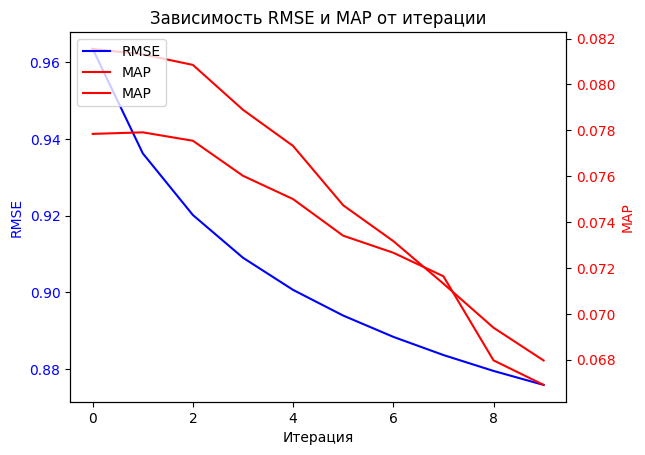

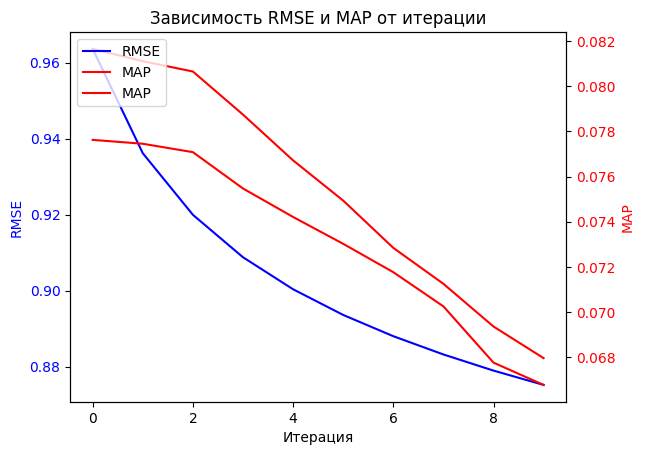

In [15]:
svd.plot_results()
svdpp.plot_results()

#P.S. Метод был написан до того, как я решил, что буду сохранять MAP для оценок от 4 и 5 в кортеж, поэтому две линии без названий получилось.